In [1]:
import gym
from gym import wrappers
import retro
import numpy as np


In [2]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from neural_exploration import *
sns.set()

In [22]:
T = int(10000)
n_arms = 6
n_features = 128
noise_std = 0.1

confidence_scaling_factor = noise_std

n_sim = 2

SEED = 42
np.random.seed(SEED)

In [23]:
color = np.array([210, 164, 74]).mean()


#prepro (210, 160, 3) uint8 frame into 7040 (88x80) 1D float vector 

def preprocess_observation(obs):

    # Next we normalize the image from -1 to +1
    obs = (obs - 128) / 128 - 1

    return obs


In [24]:

env = gym.make('SpaceInvaders-ram-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
# for i in range(10000):
# #     action = env.action_space.sample()
#     observation, reward, done, info = env.step(i%6)
# #     print(observation.shape, reward, done, info, i%6)
#     observation = preprocess_observation(observation)
#     if done: break
# env.close()


array([  0,   7,   0,  68, 241, 162,  34, 183,  68,  13, 124, 255, 255,
        50, 255, 255,   0,  36,  63,  63,  63,  63,  63,  63,  82,   0,
        23,  43,  35, 117, 180,   0,  36,  63,  63,  63,  63,  63,  63,
       110,   0,  23,   1,  60, 126, 126, 126, 126, 255, 255, 255, 195,
        60, 126, 126, 126, 126, 255, 255, 255, 195,  60, 126, 126, 126,
       126, 255, 255, 255, 195,   0,   0,  48,   3, 129,   0,   0,   0,
         0,   0,   0, 246, 246,  63,  63, 246, 246,  63,  63,   0,  21,
        24,   0,  52,  82, 196, 246,  20,   7,   0, 226,   0,   0,   0,
         0,   0,  21,  63,   0, 128, 171,   0, 255,   0, 189,   0,   0,
         0,   0,   0,  99, 255,   0,   0, 235, 254, 192, 242], dtype=uint8)

In [25]:
import numpy as np
import itertools
import random
import torch
import io


class ContextualBandit():
    def __init__(self,
                 T,
                 n_arms,
                 n_features,
                 noise_std=1.0,
                 seed=None,
                 ):
        # if not None, freeze seed for reproducibility
        self._seed(seed)
        # number of rounds
        self.T = T
        # number of arms
        self.n_arms = n_arms
        # number of features for each arm
        self.n_features = n_features
        # standard deviation of Gaussian reward noise
        self.noise_std = noise_std

        # generate random features
        self.reset()

    @property
    def arms(self):
        """Return [0, ...,n_arms-1]
        """
        return range(self.n_arms)

    def reset(self):
        """Generate new features and new rewards.
        """
        self.reset_features()
        self.reset_rewards()

    def reset_features(self):
        """Generate normalized random N(0,1) features.
        """

        self.features = []
        self.ft = []

    def reset_rewards(self):
        """Generate rewards for each arm and each round,
        following the reward function h + Gaussian noise.
        """

        self.rewards = []
        self.rt = []

    def _seed(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)


In [26]:
import numpy as np
import abc
from tqdm import tqdm


def inv_sherman_morrison(u, A_inv):
    """Inverse of a matrix with rank 1 update.
    """
    Au = np.dot(A_inv, u)
    A_inv -= np.outer(Au, Au)/(1+np.dot(u.T, Au))
    return A_inv


class UCB(abc.ABC):
    """Base class for UBC methods.
    """
    def __init__(self,
                 bandit,
                 reg_factor=1.0,
                 confidence_scaling_factor=-1.0,
                 delta=0.1,
                 train_every=1,
                 throttle=int(1e2),
                 ):
        # bandit object, contains features and generated rewards
        self.bandit = bandit
        # L2 regularization strength
        self.reg_factor = reg_factor
        # Confidence bound with probability 1-delta
        self.delta = delta
        # multiplier for the confidence bound (default is bandit reward noise std dev)
        if confidence_scaling_factor == -1.0:
            confidence_scaling_factor = bandit.noise_std
        self.confidence_scaling_factor = confidence_scaling_factor

        # train approximator only every few rounds
        self.train_every = train_every

        # throttle tqdm updates
        self.throttle = throttle

        self.reset()

    def reset_upper_confidence_bounds(self):
        """Initialize upper confidence bounds and related quantities.
        """
        self.exploration_bonus = np.empty((self.bandit.T, self.bandit.n_arms))
        self.mu_hat = np.empty((self.bandit.T, self.bandit.n_arms))
        self.upper_confidence_bounds = np.ones((self.bandit.T, self.bandit.n_arms))

    def reset_regrets(self):
        """Initialize regrets.
        """
        self.regrets = np.empty(self.bandit.T)

    def reset_actions(self):
        """Initialize cache of actions.
        """
        self.actions = np.empty(self.bandit.T).astype('int')

    def reset_A_inv(self):
        """Initialize n_arms square matrices representing the inverses
        of exploration bonus matrices.
        """
        self.A_inv = np.array(
            [
                np.eye(self.approximator_dim)/self.reg_factor for _ in self.bandit.arms
            ]
        )

    def reset_grad_approx(self):
        """Initialize the gradient of the approximator w.r.t its parameters.
        """
        self.grad_approx = np.zeros((self.bandit.n_arms, self.approximator_dim))

    def sample_action(self):
        """Return the action to play based on current estimates
        """
        return np.argmax(self.upper_confidence_bounds[self.iteration]).astype('int')

    @abc.abstractmethod
    def reset(self):
        """Initialize variables of interest.
        To be defined in children classes.
        """
        pass

    @property
    @abc.abstractmethod
    def approximator_dim(self):
        """Number of parameters used in the approximator.
        """
        pass

    @property
    @abc.abstractmethod
    def confidence_multiplier(self):
        """Multiplier for the confidence exploration bonus.
        To be defined in children classes.
        """
        pass

    @abc.abstractmethod
    def update_output_gradient(self):
        """Compute output gradient of the approximator w.r.t its parameters.
        """
        pass

    @abc.abstractmethod
    def train(self):
        """Update approximator.
        To be defined in children classes.
        """
        pass

    @abc.abstractmethod
    def predict(self):
        """Predict rewards based on an approximator.
        To be defined in children classes.
        """
        pass

    def update_confidence_bounds(self):
        """Update confidence bounds and related quantities for all arms.
        """
        self.update_output_gradient()
#         import pdb
#         pdb.set_trace()
        # UCB exploration bonus
        self.exploration_bonus[self.iteration] = np.array(
            [
                self.confidence_multiplier * np.sqrt(np.dot(self.grad_approx[a], np.dot(self.A_inv[a], self.grad_approx[a].T))) for a in self.bandit.arms
            ]
        )

        # update reward prediction mu_hat
        self.predict()

        # estimated combined bound for reward
        self.upper_confidence_bounds[self.iteration] = self.mu_hat[self.iteration] + self.exploration_bonus[self.iteration]

    def update_A_inv(self):
        self.A_inv[self.action] = inv_sherman_morrison(
            self.grad_approx[self.action],
            self.A_inv[self.action]
        )

    def run(self):
        """Run an episode of bandit.
        """
        postfix = {
            'total reward': 0.0,
            'lives': 0.0,
            'action': "a",
            "done": "",
        }
        with tqdm(total=self.bandit.T, postfix=postfix) as pbar:
            self.score = 0
            self.i = 1
            for t in range(self.bandit.T):
                # update confidence of all arms based on observed features at time t
                if t > 0:
                    
                    self.update_confidence_bounds()
                    # pick action with the highest boosted estimated reward
                    self.action = self.sample_action()
                else:
                    self.action = 0
                self.actions[t] = self.action
                observation, reward, done, info = env.step(self.action)
                observation = preprocess_observation(observation)
#                 print(done, info, reward, self.action)
                # update approximator
                if t % self.train_every == 0 and t > 0:
                    self.train()
                # update exploration indicator A_inv
                self.update_A_inv()
                self.bandit.ft.append(observation)
                self.bandit.features = np.array(self.bandit.ft)
                self.bandit.rt.append(reward)
                self.bandit.rewards = np.array(self.bandit.rt)
                # increment counter
                self.iteration += 1
                if done:
                    break
                # log
                postfix['total reward'] += reward
                postfix['lives'] = info
                postfix['action'] = self.action
                postfix['done'] = done
                
                
                if t % self.throttle == 0:
                    pbar.set_postfix(postfix)
                    pbar.update(self.throttle)


In [27]:

class Model(nn.Module):
    """Template for fully connected neural network for scalar approximation.
    """
    def __init__(self,
                 input_size=1,
                 hidden_size=2,
                 n_layers=1,
                 activation='ReLU',
                 p=0.0,
                 ):
        super(Model, self).__init__()

        self.n_layers = n_layers

        if self.n_layers == 1:
            self.layers = [nn.Linear(input_size, 1)]
        else:
            size = [input_size] + [hidden_size, ] * (self.n_layers-1) + [1]
            self.layers = [nn.Linear(size[i], size[i+1]) for i in range(self.n_layers)]
        self.layers = nn.ModuleList(self.layers)

        # dropout layer
        self.dropout = nn.Dropout(p=p)

        # activation function
        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'LeakyReLU':
            self.activation = nn.LeakyReLU(negative_slope=0.1)
        else:
            raise Exception('{} not an available activation'.format(activation))

    def forward(self, x):
        for i in range(self.n_layers-1):
            x = self.dropout(self.activation(self.layers[i](x)))
        x = self.layers[-1](x)
        return x


In [28]:
import numpy as np
import torch
import torch.nn as nn



class NeuralUCB(UCB):
    """Neural UCB.
    """
    def __init__(self,
                 bandit,
                 hidden_size=20,
                 n_layers=2,
                 reg_factor=1.0,
                 delta=0.01,
                 confidence_scaling_factor=-1.0,
                 training_window=100,
                 p=0.0,
                 learning_rate=0.01,
                 epochs=1,
                 train_every=1,
                 throttle=1,
                 use_cuda=False,
                 ):

        # hidden size of the NN layers
        self.hidden_size = hidden_size
        # number of layers
        self.n_layers = n_layers

        # number of rewards in the training buffer
        self.training_window = training_window

        # NN parameters
        self.learning_rate = learning_rate
        self.epochs = epochs

        self.use_cuda = use_cuda
#         if self.use_cuda:
#             raise Exception(
#                 'Not yet CUDA compatible : TODO for later (not necessary to obtain good results')
        self.device = torch.device('cuda' if torch.cuda.is_available() and self.use_cuda else 'cpu')

        # dropout rate
        self.p = p

        # neural network
        self.model = Model(input_size=bandit.n_features,
                           hidden_size=self.hidden_size,
                           n_layers=self.n_layers,
                           p=self.p
                           ).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # maximum L2 norm for the features across all arms and all rounds
        self.bound_features = np.max(np.linalg.norm(bandit.features, ord=2, axis=-1))

        super().__init__(bandit,
                         reg_factor=reg_factor,
                         confidence_scaling_factor=confidence_scaling_factor,
                         delta=delta,
                         throttle=throttle,
                         train_every=train_every,
                         )

    @property
    def approximator_dim(self):
        """Sum of the dimensions of all trainable layers in the network.
        """
        return sum(w.numel() for w in self.model.parameters() if w.requires_grad)

    @property
    def confidence_multiplier(self):
        """NeuralUCB confidence interval multiplier.
        """
        return (
            self.confidence_scaling_factor
            * np.sqrt(
                self.approximator_dim
                * np.log(
                    1 + self.iteration * np.max(self.bandit.features) ** 2 / (self.reg_factor * self.approximator_dim)
                    ) + 2 * np.log(1 / self.delta)
                )
            )

    def update_output_gradient(self):
        """Get gradient of network prediction w.r.t network weights.
        """
        for a in self.bandit.arms:
            x = torch.FloatTensor(
                self.bandit.features[self.iteration-1].reshape(1, -1)
            ).to(self.device)

            self.model.zero_grad()
            y = self.model(x)
            y.backward()

            self.grad_approx[a] = torch.cat(
                [w.grad.detach().flatten() / np.sqrt(self.hidden_size) for w in self.model.parameters() if w.requires_grad]
            ).to(self.device)

    def reset(self):
        """Reset the internal estimates.
        """
        self.reset_upper_confidence_bounds()
        self.reset_regrets()
        self.reset_actions()
        self.reset_A_inv()
        self.reset_grad_approx()
        self.iteration = 0

    def train(self):
        """Train neural approximator.
        """
#         iterations_so_far = range(np.max([0, self.iteration-self.training_window]), self.iteration+1)
#         actions_so_far = self.actions[np.max([0, self.iteration-self.training_window]):self.iteration+1]

        x_train = torch.FloatTensor(self.bandit.features).to(self.device)
        y_train = torch.FloatTensor(self.bandit.rewards).squeeze().to(self.device)

        # train mode
        self.model.train()
        for _ in range(self.epochs):
            y_pred = self.model.forward(x_train).squeeze()
            loss = nn.MSELoss()(y_train, y_pred)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def predict(self):
        """Predict reward.
        """
        # eval mode
        self.model.eval()
        self.mu_hat[self.iteration] = self.model.forward(
            torch.FloatTensor(self.bandit.features[self.iteration-1]).to(self.device)
        ).detach().squeeze()


In [31]:
bandit = ContextualBandit(T, n_arms, n_features, noise_std=noise_std, seed=SEED)

p = 0.2
hidden_size = 64
epochs = 100
train_every = 10
confidence_scaling_factor = 1.0
use_cuda = False

regrets = np.empty((n_sim, T))

for i in range(1):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
        
    model.run()
    print(model.actions)


  8%|▊         | 787/10000 [05:21<1:02:47,  2.45it/s, total reward=180, lives={'ale.lives': 1}, action=4, done=0]

[0 2 0 ... 0 0 0]


In [33]:
import pandas as pd
df = pd.DataFrame()

In [34]:
df["NeuralUCB"] = bandit.rewards

In [35]:
env = gym.make('SpaceInvaders-ram-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()

for i in model.actions:
    observation, reward, done, info = env.step(int(i))

    if done: break
env.close()

In [36]:

import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

In [17]:
len(model.actions)

10000

<AxesSubplot:>

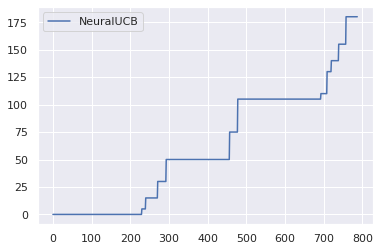

In [38]:
df.cumsum().plot()